In [52]:
%load_ext autoreload
%autoreload 2
import copy
import gc
import sys
import pickle

sys.path.append('..')

import numpy as np
import pandas as pd
import scipy.stats as sps

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, 
                                     cross_val_score)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost import XGBRegressor

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

from src.utils.cross_validation import TimeSeriesGroupSplit
from src.utils.downcasting import downcast_dtypes

sns.set(font_scale=1.2)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
max_text_features = 20
random_state = 42

BEST_CONSTANT = 0.2839
MEAN_CONSTANT = 0.3343

# XGBoost

In this notebook we will produce predictions by XGBoost.

## Preparing datasets

In this section we will load all datasets and prepare them for training.

In [3]:
sales_train = pd.read_csv('../data/processed/sales_train.csv')
train = pd.read_feather('../data/processed/train.ftr')
test = pd.read_feather('../data/processed/test.ftr')

items = pd.read_csv('../data/processed/items.csv')
tfidf_truncated_svd = pd.read_feather('../data/processed/text/tfidf_truncated-svd.ftr')

In [4]:
train.drop(columns=['index'], inplace=True)
test.drop(columns=['index', 'level_0'], inplace=True)

In [5]:
train = downcast_dtypes(train, from_bytes=32, to_bytes=16)
test = downcast_dtypes(test, from_bytes=32, to_bytes=16)

### Adding text features

In [6]:
tfidf_truncated_svd = tfidf_truncated_svd[tfidf_truncated_svd.columns[:max_text_features]]

In [7]:
tfidf_truncated_svd['item_id'] = items.item_id

In [8]:
train = pd.merge(
    train,
    tfidf_truncated_svd,
    how='left', on='item_id'
)

test = pd.merge(
    test,
    tfidf_truncated_svd,
    how='left', on='item_id'
)

gc.collect();

### Clipping target

According to evaluation, target will be clipped between 0 and 20. Let's do it in our dataset.

In [9]:
train.target = np.clip(train.target, 0, 20)

### Process categorical data

Find categorical columns.

In [10]:
categorical_types = ['object', 'bool']

In [11]:
train.dtypes[np.isin(train.dtypes.values, categorical_types)]

item_name                  object
item_in_test                 bool
item_full_category_name    object
item_category_name         object
item_subcategory_name      object
shop_name                  object
city                       object
shop_in_test                 bool
dtype: object

Don't touch boolean objects, they are already label encoded.

Let's remove columns `item_name`, `shop_name`, because we already have them label encoded as `item_id`, `shop_id`.

In [12]:
train.drop(columns=['item_name', 'shop_name'], inplace=True)
test.drop(columns=['item_name', 'shop_name'], inplace=True)

Let's define list with all categorical values.

In [13]:
categorical_features = [
    'month', 'item_id', 'item_full_category_name', 'item_category_name', 
    'item_subcategory_name', 'shop_id', 'city'
]

#### Label encoding

We will label encode only `city`, because in other cases we have already label encoded features or there are values on test, that are not present on train.

In [14]:
label_encode_features = ['city']

for column in label_encode_features:
    le = LabelEncoder()
    
    encoded_feature_train = le.fit_transform(train[column])
    train[f'{column}_labeled'] = encoded_feature_train
    
    encoded_feature_test = le.transform(test[column])
    test[f'{column}_labeled'] = encoded_feature_test

#### Mean encoding

In [15]:
for column in tqdm(categorical_features):
    # encode train
    cumsum = train.groupby(column).target.cumsum() - train.target
    cumcount = train.groupby(column).cumcount()
    encoded_feature = cumsum / cumcount
    encoded_feature.fillna(MEAN_CONSTANT, inplace=True)
    
    train[f'{column}_mean_encoded_mean'] = encoded_feature
    
    # encode test
    mean_train = train.groupby(column).target.mean()
    test[f'{column}_mean_encoded_mean'] = test[column].map(mean_train).fillna(MEAN_CONSTANT)

Drop all redundant columns.

In [16]:
to_drop = ['item_id', 'item_full_category_name', 'item_category_name', 
           'item_subcategory_name', 'city']
train.drop(columns=to_drop, inplace=True)
test.drop(columns=to_drop, inplace=True)

### Processing NaNs

Fill NaNs.

In [17]:
train.columns[train.isna().sum() > 0]

Index(['num_residents'], dtype='object')

As we expected there are some problems only with `num_residents`. We can fill it with zero, because it will be border value for this feature, trees can handle it properly.

In [18]:
train.fillna(0, inplace=True)

### Removing target

Remove target from train.

In [19]:
y = train.target
train.drop(columns=['target'], inplace=True)

### Create validation split.

Let's also delete from train rows that appears only on validation, it will make our train/validation split more consistant with train/test split.

In [20]:
X_valid = train[train.date_block_num == 33]
X_train = train[train.date_block_num < 33]
y_valid = y[train.date_block_num == 33]
y_train = y[train.date_block_num < 33]
X_test = test
    
del train, test
gc.collect()

3

## Hyperparameters tuning

In this section we will find optimum parameters for a model. Firstly, fix the result before any optimization.

In [21]:
ts = TimeSeriesGroupSplit(n_splits=5, max_train_size=int(2*10**5))

xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'seed': random_state
}

In [22]:
# default_score = cross_val_score(
#     XGBRegressor(**xgb_params), 
#     X_train, y_train, groups=X_train.date_block_num,
#     n_jobs=1, 
#     scoring='neg_root_mean_squared_error', 
#     verbose=0,
#     cv=ts
# ).mean()
# print(f'Current score: {-default_score:.5f}')

Score: $0.93931$.

### `n_estimators`

In this section we fix `learning_rate = 0.1` and try to find reasonable num of iterations.

In [56]:
X_train_dataset = xgb.DMatrix(X_train[X_train.date_block_num >= 25], 
                              label=y_train[X_train.date_block_num >= 25])
X_valid_dataset = xgb.DMatrix(X_valid, label=y_valid)

xgb.train(xgb_params, X_train_dataset, num_boost_round=500, 
          evals=[(X_train_dataset, 'train'), (X_valid_dataset, 'test')], 
          early_stopping_rounds=100)

del X_train_dataset, X_valid_dataset
gc.collect();

[0]	train-rmse:1.12536	test-rmse:1.23054
Multiple eval metrics have been passed: 'test-rmse' will be used for early stopping.

Will train until test-rmse hasn't improved in 100 rounds.
[1]	train-rmse:1.07884	test-rmse:1.18491
[2]	train-rmse:1.03437	test-rmse:1.14332
[3]	train-rmse:0.99757	test-rmse:1.10781
[4]	train-rmse:0.96505	test-rmse:1.07896
[5]	train-rmse:0.93900	test-rmse:1.05432
[6]	train-rmse:0.91405	test-rmse:1.03037
[7]	train-rmse:0.89450	test-rmse:1.00906
[8]	train-rmse:0.87981	test-rmse:0.99660
[9]	train-rmse:0.86401	test-rmse:0.98260
[10]	train-rmse:0.85090	test-rmse:0.97170
[11]	train-rmse:0.84023	test-rmse:0.96313
[12]	train-rmse:0.83123	test-rmse:0.95504
[13]	train-rmse:0.82243	test-rmse:0.94780
[14]	train-rmse:0.81518	test-rmse:0.94316
[15]	train-rmse:0.80956	test-rmse:0.93840
[16]	train-rmse:0.80376	test-rmse:0.93320
[17]	train-rmse:0.79878	test-rmse:0.93006
[18]	train-rmse:0.79512	test-rmse:0.92802
[19]	train-rmse:0.79030	test-rmse:0.92430
[20]	train-rmse:0.78677	te

[190]	train-rmse:0.71329	test-rmse:0.90656
[191]	train-rmse:0.71326	test-rmse:0.90653
[192]	train-rmse:0.71301	test-rmse:0.90664
[193]	train-rmse:0.71299	test-rmse:0.90668
[194]	train-rmse:0.71273	test-rmse:0.90650
[195]	train-rmse:0.71262	test-rmse:0.90662
[196]	train-rmse:0.71259	test-rmse:0.90663
[197]	train-rmse:0.71254	test-rmse:0.90658
[198]	train-rmse:0.71237	test-rmse:0.90664
[199]	train-rmse:0.71223	test-rmse:0.90653
[200]	train-rmse:0.71218	test-rmse:0.90649
[201]	train-rmse:0.71210	test-rmse:0.90639
[202]	train-rmse:0.71209	test-rmse:0.90640
[203]	train-rmse:0.71204	test-rmse:0.90634
[204]	train-rmse:0.71199	test-rmse:0.90633
[205]	train-rmse:0.71192	test-rmse:0.90619
[206]	train-rmse:0.71180	test-rmse:0.90624
[207]	train-rmse:0.71168	test-rmse:0.90629
[208]	train-rmse:0.71157	test-rmse:0.90639
[209]	train-rmse:0.71153	test-rmse:0.90641
[210]	train-rmse:0.71151	test-rmse:0.90661
[211]	train-rmse:0.71139	test-rmse:0.90664
[212]	train-rmse:0.71131	test-rmse:0.90662
[213]	train

In [24]:
# param_grid = {
#     'n_estimators': np.arange(50, 301, 50)
# }

# gs = GridSearchCV(
#     LGBMRegressor(**lgb_params), 
#     param_grid,          
#     n_jobs=1, 
#     scoring='neg_root_mean_squared_error', 
#     verbose=10,
#     refit=False,
#     cv=ts
# )

gs.fit(X_train, y_train, groups=X_train.date_block_num)

gs.cv_results_

gs.best_params_

In [25]:
xgb_params['n_estimators'] = 243

### Tree parameters, subsampling, regularization

Here we will find optimum values for building tree:
* `max_depth`
* `min_child_weight`

For subsampling:
* `subsample`
* `colsample_bytree`

For regularization:
* `gamma`
* `alpha`
* `lambda`

In [38]:
xgb_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'seed': random_state
}

In [47]:
def objective(params):
    """Function to optimize in hyperopt."""
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    
    current_params = copy.copy(xgb_params)
    current_params.update(params)    
    score = cross_val_score(
        XGBRegressor(**current_params), 
        X_train, y_train, groups=X_train.date_block_num,
        n_jobs=1, 
        scoring='neg_root_mean_squared_error', 
        verbose=0,
        cv=ts
    ).mean()
    
    print(f'RMSE {-score:.5f} params {params}')
    
    return {
        'loss': -score,
        'status': STATUS_OK,
    }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'min_child_weight': hp.loguniform('min_child_weight', 0, np.log(1e3)),
    'subsample': hp.uniform('subsample', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'alpha': hp.choice('alpha', [0, hp.loguniform('alpha_not_zero', np.log(1e-3), 0)]),
    'lambda': hp.choice('lambda', [0, hp.loguniform('lambda_not_zero', np.log(1e-3), 0)])
}

In [49]:
np.random.seed(random_state)
trials = Trials()
best = fmin(
    fn=objective, 
    space=space, 
    algo=tpe.suggest, 
    max_evals=120,
    trials=trials
)

RMSE 0.94092 params {'alpha': 0, 'colsample_bytree': 0.2658534106230077, 'gamma': 0.21825076621000872, 'lambda': 0.0012003414553587548, 'max_depth': 7, 'min_child_weight': 41.530679164609175, 'n_estimators': 85, 'subsample': 0.6538443477268508}
RMSE 0.92889 params {'alpha': 0, 'colsample_bytree': 0.9087418626613781, 'gamma': 0.4708818587172187, 'lambda': 0, 'max_depth': 5, 'min_child_weight': 1.0339846331488787, 'n_estimators': 45, 'subsample': 0.8794822370434191}
RMSE 0.95507 params {'alpha': 0, 'colsample_bytree': 0.5103107233526626, 'gamma': 0.23992915387459435, 'lambda': 0.07803085131780708, 'max_depth': 4, 'min_child_weight': 840.1682728826437, 'n_estimators': 70, 'subsample': 0.9404903584719024}
RMSE 0.97093 params {'alpha': 0, 'colsample_bytree': 0.5646370451050536, 'gamma': 0.41414847360627033, 'lambda': 0.0913404835495211, 'max_depth': 4, 'min_child_weight': 329.11237011427784, 'n_estimators': 65, 'subsample': 0.2417121245007965}
RMSE 1.19025 params {'alpha': 0.011926953298221

RMSE 0.93796 params {'alpha': 0.9173438569175445, 'colsample_bytree': 0.44799966424272636, 'gamma': 0.06116332077097758, 'lambda': 0.038089700853035036, 'max_depth': 7, 'min_child_weight': 6.43697481225195, 'n_estimators': 60, 'subsample': 0.9028751323943458}
RMSE 0.91912 params {'alpha': 0.4838005702893464, 'colsample_bytree': 0.5602182208963274, 'gamma': 0.11479267602383961, 'lambda': 0.011010156459318644, 'max_depth': 4, 'min_child_weight': 42.98826626056135, 'n_estimators': 55, 'subsample': 0.5290965621925413}
RMSE 0.95988 params {'alpha': 0.4222382440561614, 'colsample_bytree': 0.5656368874635419, 'gamma': 0.11074409347172046, 'lambda': 0.00212591177905177, 'max_depth': 12, 'min_child_weight': 3.8267286012447475, 'n_estimators': 60, 'subsample': 0.36100879633201444}
RMSE 0.92366 params {'alpha': 0.17903644257891937, 'colsample_bytree': 0.7650972223865575, 'gamma': 0.0057217110271653715, 'lambda': 0.010968640990672579, 'max_depth': 4, 'min_child_weight': 14.215209966938277, 'n_esti

RMSE 0.92392 params {'alpha': 0, 'colsample_bytree': 0.9213622744035943, 'gamma': 0.2957641052021345, 'lambda': 0, 'max_depth': 6, 'min_child_weight': 12.248624937245287, 'n_estimators': 30, 'subsample': 0.9795782749529477}
RMSE 0.92815 params {'alpha': 0, 'colsample_bytree': 0.8778631919346319, 'gamma': 0.3125758888036036, 'lambda': 0, 'max_depth': 7, 'min_child_weight': 5.0188824099042115, 'n_estimators': 40, 'subsample': 0.7806427164696779}
RMSE 0.91962 params {'alpha': 0, 'colsample_bytree': 0.9924565251237674, 'gamma': 0.28225234608951677, 'lambda': 0, 'max_depth': 6, 'min_child_weight': 3.1944445049578936, 'n_estimators': 25, 'subsample': 0.9683051122208592}
RMSE 0.91804 params {'alpha': 0, 'colsample_bytree': 0.8300291948699432, 'gamma': 0.2213809759248312, 'lambda': 0, 'max_depth': 5, 'min_child_weight': 34.28948353998943, 'n_estimators': 20, 'subsample': 0.9040595906136595}
RMSE 0.92240 params {'alpha': 0, 'colsample_bytree': 0.9655368094800417, 'gamma': 0.3321181291143065, 'l

RMSE 0.92532 params {'alpha': 0.0028724381130697716, 'colsample_bytree': 0.9375779761653602, 'gamma': 0.14702646449173504, 'lambda': 0, 'max_depth': 4, 'min_child_weight': 30.25510283102423, 'n_estimators': 20, 'subsample': 0.5366267798352207}
RMSE 0.92635 params {'alpha': 0, 'colsample_bytree': 0.8205646582900987, 'gamma': 0.2897632970985841, 'lambda': 0, 'max_depth': 6, 'min_child_weight': 66.43744680531496, 'n_estimators': 55, 'subsample': 0.6706988044350186}
RMSE 0.92514 params {'alpha': 0, 'colsample_bytree': 0.7865084285890103, 'gamma': 0.2677083110722619, 'lambda': 0, 'max_depth': 5, 'min_child_weight': 158.29841252933923, 'n_estimators': 30, 'subsample': 0.6953706224681595}
RMSE 1.00342 params {'alpha': 0, 'colsample_bytree': 0.1785422293827325, 'gamma': 0.4302513698713476, 'lambda': 0, 'max_depth': 7, 'min_child_weight': 36.46729142329871, 'n_estimators': 15, 'subsample': 0.7887915947807087}
RMSE 0.94356 params {'alpha': 0.001492422504575843, 'colsample_bytree': 0.275151441325

In [55]:
with open('../models/xgb/hyperopt/trials.pkl', 'wb') as ouf:
    pickle.dump(trials, ouf)

In [50]:
best

{'alpha': 0,
 'colsample_bytree': 0.8983382780951911,
 'gamma': 0.36098465900010335,
 'lambda': 0,
 'max_depth': 6.0,
 'min_data_in_leaf': 66.772865318461,
 'n_estimators': 20.0,
 'subsample': 0.5756482276926338}

In [64]:
xgb_params['max_depth'] = 6
xgb_params['min_child_weight'] = 66.773

xgb_params['subsample'] = 0.576
xgb_params['colsample_bytree'] = 0.898

xgb_params['gamma'] = 0.361
xgb_params['alpha'] = 0
xgb_params['lambda'] = 0

xgb_params['n_estimators'] = 243

### Reduce learning rate

Current score:

In [65]:
current_score = cross_val_score(
    XGBRegressor(**xgb_params), 
    X_train, y_train, groups=X_train.date_block_num,
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=0,
    cv=ts
).mean()
print(f'Current score: {-current_score:.5f}')

Current score: 0.92766


Score: $0.92487$.

Now we can half our `learning rate` and double `n_estimators`.

In [67]:
xgb_params

{'objective': 'reg:squarederror',
 'learning_rate': 0.1,
 'seed': 42,
 'max_depth': 6,
 'min_child_weight': 66.773,
 'subsample': 0.576,
 'colsample_bytree': 0.898,
 'gamma': 0.361,
 'alpha': 0,
 'lambda': 0,
 'n_estimators': 243}

In [68]:
xgb_params_changed = copy.copy(xgb_params)
xgb_params_changed['learning_rate'] /= 2
xgb_params_changed['n_estimators'] = int(xgb_params['n_estimators'] * 2)

In [69]:
score_after_change = cross_val_score(
    XGBRegressor(**xgb_params_changed), 
    X_train, y_train, groups=X_train.date_block_num,
    n_jobs=1, 
    scoring='neg_root_mean_squared_error', 
    verbose=0,
    cv=ts
).mean()

print(f'Score after changing: {-score_after_change:.5f}')

Score after changing: 0.92353


Score: $0.92353$.

It helped, but computations was too long.

In [70]:
xgb_params

{'objective': 'reg:squarederror',
 'learning_rate': 0.1,
 'seed': 42,
 'max_depth': 6,
 'min_child_weight': 66.773,
 'subsample': 0.576,
 'colsample_bytree': 0.898,
 'gamma': 0.361,
 'alpha': 0,
 'lambda': 0,
 'n_estimators': 243}

## Validation

In this section we will validate best parameters using haldout. We will use not all train, because of limitation of RAM.

In [71]:
(X_train.date_block_num >= 25).sum()

1627417

In [72]:
start_date_block_num = 25
indices_train = (X_train.date_block_num >= start_date_block_num)
X_train = X_train[indices_train]
y_train = y_train[indices_train]
gc.collect();

In [73]:
model = XGBRegressor(**xgb_params)
model.fit(X_train, y_train)

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.898, gamma=0.361, gpu_id=-1,
             importance_type='gain', interaction_constraints='', lambda=0,
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=66.773, missing=nan, monotone_constraints='()',
             n_estimators=243, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=42,
             subsample=0.576, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [74]:
y_predicted = np.clip(model.predict(X_valid), 0, 20)
validation_score = mean_squared_error(y_valid, y_predicted)
print(f'Validation score: {validation_score:.5f}')

Validation score: 0.81906


Score: $0.81906$

Let's look at predicted values charasteristics.

In [75]:
pd.Series(y_predicted).describe()

count    168139.000000
mean          0.369857
std           0.949277
min           0.000000
25%           0.048310
50%           0.146863
75%           0.335070
max          20.000000
dtype: float64

Let's look at feature importances.

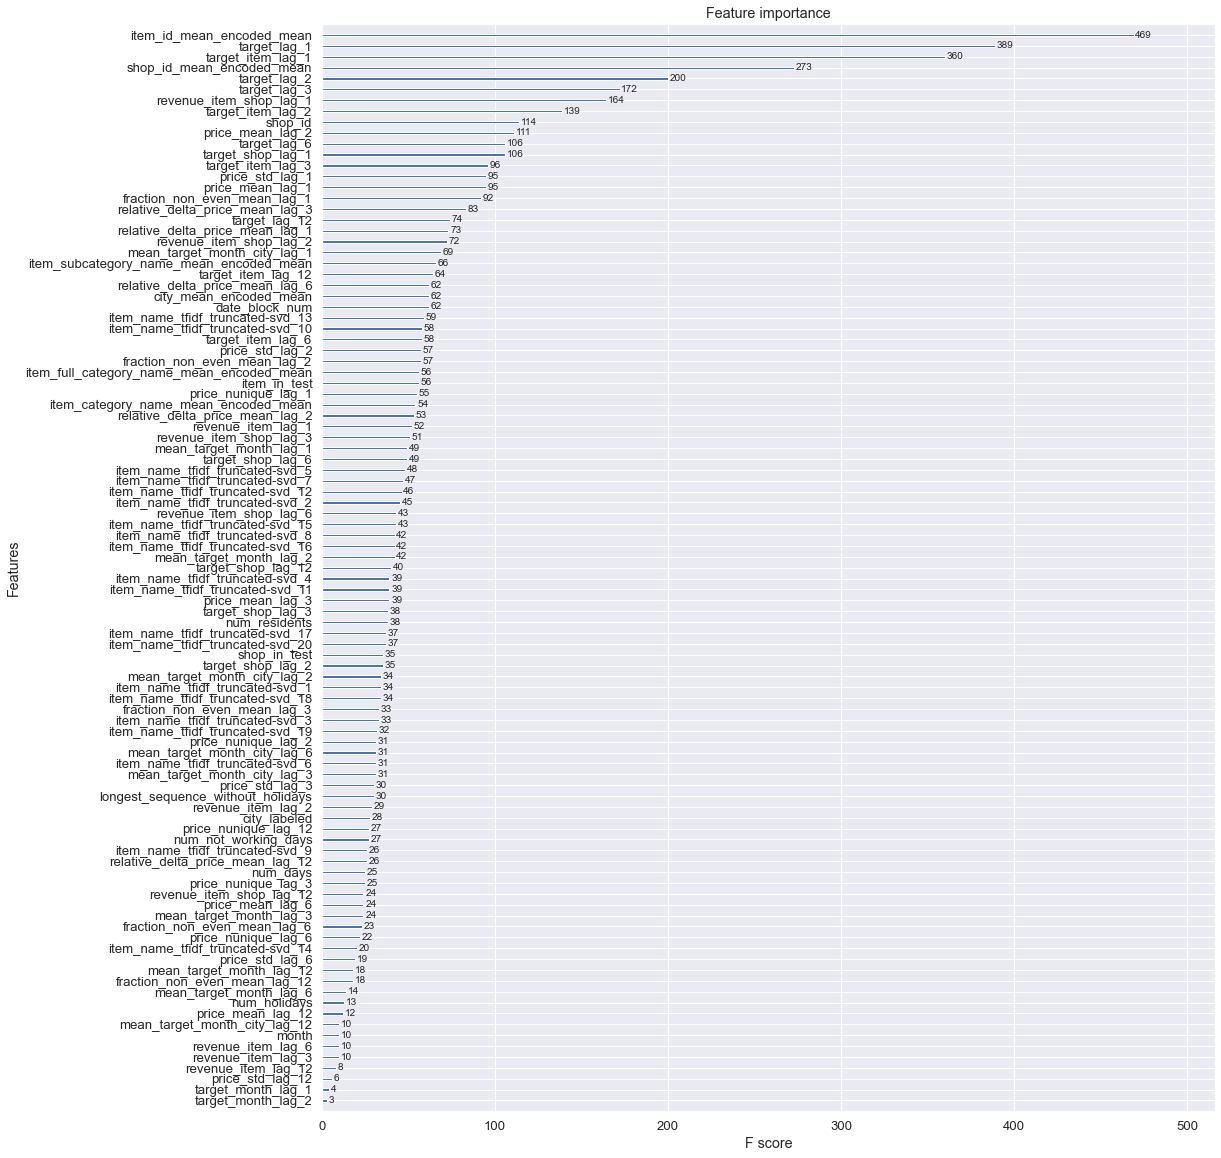

In [84]:
fig, ax = plt.subplots(figsize=(16, 20))
xgb.plot_importance(model, ax=ax);

## Submit

In this section we will train result model and submit prediction. Don't forget to clip values according to [evaluation tab](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview/evaluation) (but ay be for tree-based methods it is not necessary).

In [85]:
X_train = pd.concat((X_train, X_valid))
y_train = pd.concat((y_train, y_valid))
gc.collect();

In [86]:
X_train.shape

(1795556, 109)

In [87]:
start_date_block_num = 25
indices_train = (X_train.date_block_num >= start_date_block_num)
X_train = X_train[indices_train]
y_train = y_train[indices_train]
gc.collect();

In [88]:
model = XGBRegressor(**xgb_params)
bags = 5

bagged_predictions = np.zeros(X_test.shape[0])
for n in tqdm(range(bags)):
    model.set_params(random_state=random_state+n)
    model.fit(X_train, y_train)
    bagged_predictions += np.clip(model.predict(X_test), 0, 20)
    gc.collect()
    
bagged_predictions /= bags

Create submission.

In [89]:
pd.Series(bagged_predictions).describe()

count    214200.000000
mean          0.375572
std           0.750579
min           0.000000
25%           0.114563
50%           0.212187
75%           0.396909
max          20.000000
dtype: float64

In [90]:
submission = pd.read_csv('../data/raw/sample_submission.csv')
submission['item_cnt_month'] = bagged_predictions
submission.to_csv('../models/xgb/submission.csv', index=False)

!kaggle competitions submit competitive-data-science-predict-future-sales -f ../models/xgb/submission.csv -m "XGBoost"

Result is $1.01051$. It is pretty far from top positions.

## OOF predictions

In this section we will create out-of-fold predictions for stacking.